In [213]:
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from pprint import pprint
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import Counter
import re
from scipy import stats
from matplotlib import ticker as mticker



pd.set_option("display.max_columns", None)

RES_OPEN = "open PR"
RES_ACCEPT = "accepted PR"
RES_ABANDON = "abandoned PR"

In [84]:
bot_pr_df = pd.read_csv("bot_PR.csv")
ex_pr_df = pd.read_csv("external_PR.csv")
in_pr_df = pd.read_csv("internal_PR.csv")
print(len(bot_pr_df)+len(ex_pr_df)+len(in_pr_df))

945291


In [85]:
bot_temp = bot_pr_df.groupby(["package_key", "pr_state", "pr_merged"]).size().reset_index(name='counts')
bot_temp['pr_group'] = 'Bot'

ex_temp = ex_pr_df.groupby(["package_key", "pr_state", "pr_merged"]).size().reset_index(name='counts')
ex_temp['pr_group'] = 'External'

in_temp = in_pr_df.groupby(["package_key", "pr_state", "pr_merged"]).size().reset_index(name='counts')
in_temp['pr_group'] = 'Internal'

In [87]:
# combined_dict = {}
frames = [bot_temp, ex_temp, in_temp]
combined_df = pd.concat(frames, ignore_index=True)
combined_df['counts_log_e'] = np.log(combined_df['counts'])

conditions = [
    (combined_df['pr_state'] == "open") & (combined_df['pr_merged'] == False),
    (combined_df['pr_state'] == "closed") & (combined_df['pr_merged'] == False),
    (combined_df['pr_state'] == "closed") & (combined_df['pr_merged'] == True),
]
values = ['open PR', 'abandoned PR', 'accepted PR']

combined_df['res_type'] = np.select(conditions, values)

print(sum(combined_df["counts"].tolist()))

combined_df

945291


,package_key,pr_state,pr_merged,counts,pr_group,counts_log_e,res_type
0,00dani:gulp-dest-atomic,open,False,2,Bot,0.693147,open PR
1,1000ch:array-find,closed,True,1,Bot,0.000000,accepted PR
2,1000ch:grunt-image,closed,True,3,Bot,1.098612,accepted PR
3,1000ch:gulp-dwebp,closed,True,1,Bot,0.000000,accepted PR
4,1000ch:gulp-image,closed,True,1,Bot,0.000000,accepted PR
...,...,...,...,...,...,...,...
96061,zzarcon:clay,closed,True,3,Internal,1.098612,accepted PR
96062,zzarcon:microm,closed,False,1,Internal,0.000000,abandoned PR
96063,zzarcon:microm,closed,True,4,Internal,1.386294,accepted PR
96064,zzarcon:react-keypress,open,False,1,Internal,0.000000,open PR


In [235]:
package_df = combined_df.groupby(["package_key"])["counts"].sum().reset_index(name='pck_pr_counts')
result = pd.merge(combined_df, package_df, how="outer", on=["package_key"])
result['ratio'] = result['counts'] / result['pck_pr_counts']
result['percentage'] = result['ratio'] * 100
result.sort_values("package_key")

,package_key,pr_state,pr_merged,counts,pr_group,counts_log_e,res_type,counts_log_10,pck_pr_counts,ratio,percentage
47818,007design:gulp-prefix,closed,True,3,External,1.098612,accepted PR,0.477121,4,0.750000,75.000000
47819,007design:gulp-prefix,open,False,1,External,0.000000,open PR,0.000000,4,0.250000,25.000000
0,00dani:gulp-dest-atomic,open,False,2,Bot,0.693147,open PR,0.301030,2,1.000000,100.000000
47820,0dp:generator-wp-bones,closed,True,10,External,2.302585,accepted PR,1.000000,10,1.000000,100.000000
47821,0neSe7en:node-etcd-config,closed,True,2,External,0.693147,accepted PR,0.301030,2,1.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
91806,zzyss86:LunarCalendar,open,False,2,External,0.693147,open PR,0.301030,6,0.333333,33.333333
91805,zzyss86:LunarCalendar,closed,True,3,External,1.098612,accepted PR,0.477121,6,0.500000,50.000000
91804,zzyss86:LunarCalendar,closed,False,1,External,0.000000,abandoned PR,0.000000,6,0.166667,16.666667
91807,zzzhan:grunt-cipher,closed,True,1,External,0.000000,accepted PR,0.000000,1,1.000000,100.000000


## ===== Graph =====

#### ratio ========

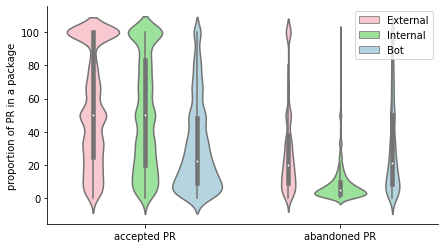

In [237]:
# Create an array with the colors you want to use
colors = ["pink", "lightgreen", "lightblue"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(7, 4))
ax = sns.violinplot(x="res_type", y="percentage", hue="pr_group",data=result[result["pr_group"]!="open PR"], 
                    order=['accepted PR', 'abandoned PR'],
                    hue_order=["External", "Internal", "Bot"],
                    palette=customPalette)
# ax.set(yscale="log")
plt.legend(loc='upper right')

# ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.1f}}}$"))
ax.set(xlabel='', ylabel='proportion of PR in a package')
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# plt.legend([],[], frameon=False)

plt.savefig("rq2_response.pdf")

In [238]:
values = ['accepted PR', 'abandoned PR', 'open PR']
groups = ['External', 'Internal', 'Bot']

for res in values:
    for group in groups:
        selected_df = result.loc[(result.res_type==res)&(result.pr_group==group), "percentage"]
        selected_mean = selected_df.mean()
        selected_median = selected_df.median()
        selected_std = selected_df.std()
        print(f"{res}-{group}:: \n\tmean:{selected_mean}\tmedian:{selected_median}\tsd:{selected_std}")

accepted PR-External:: 
	mean:55.64907409119309	median:50.0	sd:33.88489613662416
accepted PR-Internal:: 
	mean:51.03607384225855	median:50.0	sd:33.53595359294394
accepted PR-Bot:: 
	mean:30.944375731189453	median:22.727272727272727	sd:26.776204593223298
abandoned PR-External:: 
	mean:29.03599971298537	median:20.0	sd:27.19472716559803
abandoned PR-Internal:: 
	mean:8.289874379859018	median:5.3050771135877515	sd:9.52978935664866
abandoned PR-Bot:: 
	mean:31.183604374871816	median:21.052631578947366	sd:28.104120898547833
open PR-External:: 
	mean:38.65279990351402	median:25.0	sd:35.90897208897069
open PR-Internal:: 
	mean:7.699582625316722	median:3.125	sd:11.282282243880497
open PR-Bot:: 
	mean:36.127761197110864	median:22.623655913978492	sd:34.09840856436167


## ======= Statistical Validation =======
##### (Kruskal Wallis H test, Mann-Whitney U test, Dunn Test, cliffsDelta)

In [201]:
def cliffsDelta(lst1, lst2, **dull):

    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d, size

def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two
    
def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'

#### === ratio ======

In [240]:
print(">>Kruskal test for 3 status of 3 group<<")
for res in values:
    list_1 = list(result.loc[(result.res_type==res)&(result.pr_group==groups[0]), "ratio"])
    list_2 = list(result.loc[(result.res_type==res)&(result.pr_group==groups[1]), "ratio"])
    list_3 = list(result.loc[(result.res_type==res)&(result.pr_group==groups[2]), "ratio"])

    print(res,':',stats.kruskal(list_1, list_2, list_3))

>>Kruskal test for 3 status of 3 group<<
accepted PR : KruskalResult(statistic=3128.3094405616944, pvalue=0.0)
abandoned PR : KruskalResult(statistic=4540.017099770218, pvalue=0.0)
open PR : KruskalResult(statistic=1759.836085353476, pvalue=0.0)


In [233]:
print(">>Mann-Whitney U test of accepted External PR and abandoned External PR<<")
list_1 = list(result.loc[(result.res_type=="accepted PR")&(result.pr_group=="External"), "ratio"])
list_2 = list(result.loc[(result.res_type=="abandoned PR")&(result.pr_group=="External"), "ratio"])
print(stats.mannwhitneyu(list_1,list_2))
d, res = cliffsDelta(list_1,list_2)
print(d, res)

>>Mann-Whitney U test of accepted External PR and abandoned External PR<<
MannwhitneyuResult(statistic=97345002.0, pvalue=0.0)
0.46021915329272245 medium


In [234]:
print(">>Mann-Whitney U test accepted and abandoned of each group<<")
for response in values:
    for i in range(0,3):
        j = (i+1)%3
        list_1 = list(result.loc[(result.res_type==response)&(result.pr_group==groups[i]), "ratio"])
        list_2 = list(result.loc[(result.res_type==response)&(result.pr_group==groups[j]), "ratio"])
        print(f"{response}: {groups[i]} vs {groups[j]}",stats.mannwhitneyu(list_1,list_2))
        d, res = cliffsDelta(list_1,list_2)
        print("\t",d, res)

>>Mann-Whitney U test accepted and abandoned of each group<<
accepted PR: External vs Internal MannwhitneyuResult(statistic=203348978.5, pvalue=1.3988692166016654e-52)
	 0.08572815834737307 negligible
accepted PR: Internal vs Bot MannwhitneyuResult(statistic=39807124.0, pvalue=0.0)
	 0.3525237620290291 medium
accepted PR: Bot vs External MannwhitneyuResult(statistic=51964616.5, pvalue=0.0)
	 -0.42737071485775746 medium
abandoned PR: External vs Internal MannwhitneyuResult(statistic=14256937.5, pvalue=0.0)
	 0.6075729072013893 large
abandoned PR: Internal vs Bot MannwhitneyuResult(statistic=8493784.5, pvalue=0.0)
	 -0.589203720320437 large
abandoned PR: Bot vs External MannwhitneyuResult(statistic=54925532.0, pvalue=0.0006936378333589737)
	 0.0258220891145377 negligible
open PR: External vs Internal MannwhitneyuResult(statistic=2826409.0, pvalue=0.0)
	 0.6453378812858167 large
open PR: Internal vs Bot MannwhitneyuResult(statistic=1917507.5, pvalue=0.0)
	 -0.6331905316660067 large
open P

### ====== Dunn test =========

In [247]:
#perform Dunn's test using a Bonferonni correction for the p-values
import scikit_posthocs as sp
# sp.posthoc_dunn(data, p_adjust = 'bonferroni')

for res in values:
    list_1 = list(result.loc[(result.res_type==res)&(result.pr_group==groups[0]), "ratio"])
    list_2 = list(result.loc[(result.res_type==res)&(result.pr_group==groups[1]), "ratio"])
    list_3 = list(result.loc[(result.res_type==res)&(result.pr_group==groups[2]), "ratio"])

    print(res,':',groups)
    print(sp.posthoc_dunn([list_1, list_2, list_3], p_adjust = 'bonferroni'))

accepted PR : ['External', 'Internal', 'Bot']
              1             2    3
1  1.000000e+00  8.771894e-50  0.0
2  8.771894e-50  1.000000e+00  0.0
3  0.000000e+00  0.000000e+00  1.0
abandoned PR : ['External', 'Internal', 'Bot']
          1    2         3
1  1.000000  0.0  0.092244
2  0.000000  1.0  0.000000
3  0.092244  0.0  1.000000
open PR : ['External', 'Internal', 'Bot']
          1    2         3
1  1.000000  0.0  0.000094
2  0.000000  1.0  0.000000
3  0.000094  0.0  1.000000
